In [1]:
import pandas as pd
import numpy as np
import random
import re
import os
import matplotlib.pyplot as plt
import math
from wordcloud import WordCloud
from tqdm import tqdm
import time
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from bertopic import BERTopic
from top2vec import Top2Vec
from collections import Counter
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
import umap.umap_ as umap
import hdbscan
import seaborn as sns

c:\Users\thean\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Đọc dữ liệu và chuẩn bị

In [2]:
# --- Cấu hình đường dẫn ---
input_path = r"C:/Users/thean/Documents/Social_Network/Social_Network_Projects/Dataset/Project2C_youtube_data_cleaned.csv"

# Đọc dữ liệu đã làm sạch
df = pd.read_csv(input_path)

# Tách token đã xử lý
texts = [str(t).split() for t in df["clean_description"].fillna("")]
print(f" Dữ liệu: {len(texts)} dòng")


 Dữ liệu: 7653 dòng


Tạo corpus và dictionary cho LDA

In [3]:
dictionary = corpora.Dictionary(texts)
dictionary.compactify()  # Đảm bảo ID liên tục
corpus = [dictionary.doc2bow(text) for text in texts]
print(f" Từ điển: {len(dictionary)} từ")

 Từ điển: 36530 từ


In [4]:
def evaluate_lda_topics(dictionary, corpus, texts, start=5, limit=40, step=5, sample_ratio=1.0, 
                        save_dir="lda_models", coherence_measure="c_v"):
    """
    Huấn luyện nhiều mô hình LDA với số lượng chủ đề khác nhau và đánh giá bằng perplexity & coherence score.

    Tham số:
    ----------
    dictionary : gensim.corpora.Dictionary
        Từ điển ánh xạ id <-> từ.
    corpus : list of list of (int, int)
        Dữ liệu dạng BoW.
    texts : list of list of str
        Dữ liệu văn bản đã được tiền xử lý (tokenized).
    start, limit, step : int
        Khoảng giá trị số chủ đề (num_topics) cần kiểm thử.
    sample_ratio : float
        Tỷ lệ mẫu của corpus dùng để huấn luyện (ví dụ 0.5 = 50% dữ liệu).
    save_dir : str
        Thư mục lưu các mô hình LDA đã huấn luyện.
    coherence_measure : str
        Loại độ đo coherence: 'u_mass', 'c_v', 'c_uci', 'c_npmi'.

    Trả về:
    ---------
    DataFrame chứa:
      - num_topics
      - perplexity
      - coherence
      - training_time_sec
      - model_path
    """

    os.makedirs(save_dir, exist_ok=True)
    results = []

    # Dùng 1 phần dữ liệu
    if sample_ratio < 1.0:
        sample_size = int(len(corpus) * sample_ratio)
        corpus_sample = corpus[:sample_size]
        texts_sample = texts[:sample_size]
    else:
        corpus_sample = corpus
        texts_sample = texts

    for num_topics in tqdm(range(start, limit + 1, step), desc="Đang huấn luyện các mô hình LDA"):
        try:
            start_time = time.time()

            lda_model = LdaModel(
                corpus=corpus_sample,
                id2word=dictionary,
                num_topics=num_topics,
                passes=5,
                iterations=50,
                random_state=42
            )

            model_path = os.path.join(save_dir, f"lda_model_{num_topics}.model")
            lda_model.save(model_path)

            # Tính perplexity và coherence
            perplexity = lda_model.log_perplexity(corpus_sample)
            coherence_model = CoherenceModel(
                model=lda_model,
                texts=texts_sample,
                dictionary=dictionary,
                coherence=coherence_measure
            )
            coherence = coherence_model.get_coherence()

            elapsed = time.time() - start_time

            results.append({
                "num_topics": num_topics,
                "perplexity": perplexity,
                "coherence": coherence,
                "training_time_sec": round(elapsed, 2),
                "model_path": model_path
            })

            print(f" Đã huấn luyện {num_topics} chủ đề → Coherence={coherence:.4f}, Perplexity={perplexity:.2f}")

        except Exception as e:
            print(f" Lỗi với num_topics={num_topics}: {e}")
            continue

    df_results = pd.DataFrame(results)
    df_results.sort_values(by="coherence", ascending=False, inplace=True)
    print("\n Mô hình tối ưu (theo coherence):")
    print(df_results.head(3))

    return df_results


In [7]:
df_eval = evaluate_lda_topics(dictionary, corpus, texts, start=5, limit=40, step=5)
print(df_eval)

Đang huấn luyện các mô hình LDA:  12%|█▎        | 1/8 [00:35<04:10, 35.81s/it]

 Đã huấn luyện 5 chủ đề → Coherence=0.5489, Perplexity=-7.78


Đang huấn luyện các mô hình LDA:  25%|██▌       | 2/8 [01:11<03:32, 35.46s/it]

 Đã huấn luyện 10 chủ đề → Coherence=0.4819, Perplexity=-8.23


Đang huấn luyện các mô hình LDA:  38%|███▊      | 3/8 [01:46<02:57, 35.53s/it]

 Đã huấn luyện 15 chủ đề → Coherence=0.5321, Perplexity=-9.28


Đang huấn luyện các mô hình LDA:  50%|█████     | 4/8 [02:23<02:23, 35.92s/it]

 Đã huấn luyện 20 chủ đề → Coherence=0.5094, Perplexity=-9.90


Đang huấn luyện các mô hình LDA:  62%|██████▎   | 5/8 [03:00<01:49, 36.56s/it]

 Đã huấn luyện 25 chủ đề → Coherence=0.4840, Perplexity=-10.44


Đang huấn luyện các mô hình LDA:  75%|███████▌  | 6/8 [03:40<01:15, 37.54s/it]

 Đã huấn luyện 30 chủ đề → Coherence=0.5141, Perplexity=-10.98


Đang huấn luyện các mô hình LDA:  88%|████████▊ | 7/8 [04:22<00:38, 38.95s/it]

 Đã huấn luyện 35 chủ đề → Coherence=0.5248, Perplexity=-11.53


Đang huấn luyện các mô hình LDA: 100%|██████████| 8/8 [05:14<00:00, 39.29s/it]

 Đã huấn luyện 40 chủ đề → Coherence=0.4822, Perplexity=-12.09

 Mô hình tối ưu (theo coherence):
   num_topics  perplexity  coherence  training_time_sec  \
0           5   -7.783073   0.548878              35.81   
2          15   -9.282174   0.532089              35.61   
6          35  -11.527735   0.524757              41.84   

                      model_path  
0   lda_models\lda_model_5.model  
2  lda_models\lda_model_15.model  
6  lda_models\lda_model_35.model  
   num_topics  perplexity  coherence  training_time_sec  \
0           5   -7.783073   0.548878              35.81   
2          15   -9.282174   0.532089              35.61   
6          35  -11.527735   0.524757              41.84   
5          30  -10.984895   0.514107              39.45   
3          20   -9.901669   0.509423              36.51   
4          25  -10.438422   0.484009              37.69   
7          40  -12.092892   0.482237              52.22   
1          10   -8.230442   0.481868              35.

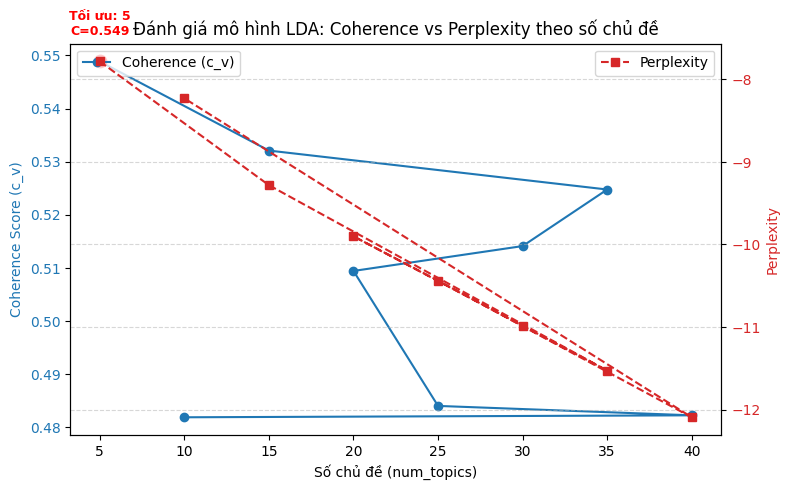

In [9]:
best_idx = df_eval["coherence"].idxmax()
best_num_topics = df_eval.loc[best_idx, "num_topics"]
best_coherence = df_eval.loc[best_idx, "coherence"]
best_perplexity = df_eval.loc[best_idx, "perplexity"]

# --- Vẽ biểu đồ song trục ---
fig, ax1 = plt.subplots(figsize=(8,5))

# Trục trái: Coherence
color = 'tab:blue'
ax1.set_xlabel("Số chủ đề (num_topics)")
ax1.set_ylabel("Coherence Score (c_v)", color=color)
ax1.plot(df_eval["num_topics"], df_eval["coherence"], marker='o', color=color, label="Coherence (c_v)")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper left")

# Đánh dấu điểm tốt nhất
ax1.scatter(best_num_topics, best_coherence, color='red', s=80, zorder=5)
ax1.text(best_num_topics, best_coherence + 0.005, 
         f"Tối ưu: {best_num_topics}\nC={best_coherence:.3f}", 
         color='red', ha='center', fontsize=9, weight='bold')

# Trục phải: Perplexity
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Perplexity", color=color)
ax2.plot(df_eval["num_topics"], df_eval["perplexity"], marker='s', color=color, linestyle='--', label="Perplexity")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper right")

plt.title("Đánh giá mô hình LDA: Coherence vs Perplexity theo số chủ đề")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Số chủ đề tối ưu nhất là 5

Coherence cao nhất (~0.55)

Perplexity chưa quá cao


Huấn luyện LDA, BERTopic, Top2Vec

In [6]:
best_num = 5  # số topic tối ưu từ đánh giá coherence/perplexity
lda_model_path = f"lda_models/lda_model_{best_num}.model"

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_num,
    passes=20,          # số lần lặp toàn bộ corpus
    iterations=100,     # số vòng lặp nội bộ để hội tụ tốt hơn
    random_state=42
)

lda_model.save(lda_model_path)
print(f" Đã huấn luyện và lưu mô hình LDA tại: {lda_model_path}")

 Đã huấn luyện và lưu mô hình LDA tại: lda_models/lda_model_5.model


In [5]:

# =========================
# LDA MODEL
# =========================
best_num = 5 # số topic tối ưu từ đánh giá perplexity
lda_model_path = f"lda_models/lda_model_{best_num}.model"

if os.path.exists(lda_model_path):
    lda_model = LdaModel.load(lda_model_path)
    print(f" Đã load mô hình LDA với {best_num} chủ đề: {lda_model_path}")
else:
    # Nếu chưa có model, huấn luyện mới
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=best_num,
        passes=20,
        workers=max(1, os.cpu_count() - 1),
        random_state=42
    )
    lda_model.save(lda_model_path)
    print(f" Đã huấn luyện và lưu mô hình LDA: {lda_model_path}")

# =========================
#  BERTopic MODEL
# =========================
texts_bertopic = df["clean_description"].dropna().astype(str).tolist()
bertopic_model_path = "bertopic_model"

if os.path.exists(bertopic_model_path):
    bertopic_model = BERTopic.load(bertopic_model_path)
    print(f" Đã load mô hình BERTopic: {bertopic_model_path}")
else:
    bertopic_model = BERTopic(
        language="multilingual",
        calculate_probabilities=True,
        verbose=True,
        nr_topics=None  # để BERTopic tự chọn số chủ đề tối ưu
    )
    topics_bertopic, probs = bertopic_model.fit_transform(texts_bertopic)
    bertopic_model.save(bertopic_model_path)
    print(f" Đã huấn luyện và lưu mô hình BERTopic: {bertopic_model_path}")

# =========================
#  Top2Vec MODEL
# =========================
texts_top2vec = df["clean_description"].dropna().astype(str).tolist()
top2vec_model_path = "top2vec_model"

if os.path.exists(top2vec_model_path):
    top2vec_model = Top2Vec.load(top2vec_model_path)
    print(f" Đã load mô hình Top2Vec: {top2vec_model_path}")
else:
    top2vec_model = Top2Vec(
        documents=texts_top2vec,
        speed="learn",
        workers=8  # giảm nếu gặp lỗi đa luồng
    )

    # Lấy topic và score cho từng văn bản
    doc_topics = top2vec_model.get_documents_topics(
        doc_ids=list(range(len(texts_top2vec)))
    )

    # Tách riêng topic và score
    topics_top2vec = [t[0] for t in doc_topics]
    scores_top2vec = [t[1] for t in doc_topics]

    # Lưu mô hình
    top2vec_model.save(top2vec_model_path)
    print(f" Đã huấn luyện và lưu mô hình Top2Vec: {top2vec_model_path}")

 Đã load mô hình LDA với 5 chủ đề: lda_models/lda_model_5.model
 Đã load mô hình BERTopic: bertopic_model
 Đã load mô hình Top2Vec: top2vec_model


In [6]:
# --- Chuẩn bị dữ liệu ---
texts = df["clean_description"].dropna().astype(str).tolist()

# --- LDA: Gán topic có xác suất cao nhất cho mỗi tài liệu ---
lda_pred_topics = [
    max(doc, key=lambda x: x[1])[0] if len(doc) > 0 else -1
    for doc in lda_model[corpus]
]
print(f" LDA: Gán {len(lda_pred_topics)} topic cho tài liệu.")

# --- BERTopic: Dùng transform() để lấy topic mỗi tài liệu ---
bertopic_pred_topics, _ = bertopic_model.transform(texts)
print(f" BERTopic: Gán {len(bertopic_pred_topics)} topic cho tài liệu.")

# --- Top2Vec: Lấy topic tương ứng mỗi document ---
result = top2vec_model.get_documents_topics(doc_ids=list(range(len(texts))))
# Top2Vec trả về tuple (topics, scores, words) → lấy topics
if isinstance(result, (list, tuple)):
    top2vec_pred_topics = result[0]
else:
    top2vec_pred_topics = result
print(f" Top2Vec: Gán {len(top2vec_pred_topics)} topic cho tài liệu.")

 LDA: Gán 7653 topic cho tài liệu.


Batches: 100%|██████████| 240/240 [02:28<00:00,  1.61it/s]


 BERTopic: Gán 7653 topic cho tài liệu.
 Top2Vec: Gán 7653 topic cho tài liệu.


# Đánh giá mô hình

LDA: Perplexity, C_V, U_Mass, NPMI, Diversity, Interpretability

Tất cả mô hình: Topic Diversity

Nếu có nhãn category_name: NMI, ARI, Purity

In [11]:
for cat_id, cat_name in df[["category_id", "category_name"]].drop_duplicates().values:
    print(f"{cat_id}: {cat_name}")
    
category_vi = {
    "Howto & Style": "Cách làm & Phong cách",
    "People & Blogs": "Con người & Blog",
    "Sports": "Thể thao",
    "Entertainment": "Giải trí",
    "Science & Technology": "Khoa học & Công nghệ",
    "Music": "Âm nhạc",
    "Gaming": "Trò chơi",
    "Comedy": "Hài hước",
    "Education": "Giáo dục",
    "Autos & Vehicles": "Xe cộ",
    "News & Politics": "Tin tức & Chính trị",
    "Travel & Events": "Du lịch & Sự kiện",
    "Pets & Animals": "Thú cưng & Động vật",
    "Film & Animation": "Phim & Hoạt hình",
    "nan": "Khác"
}

# ====== THÊM CỘT CATEGORY VIETNAMESE ======
df["category_name_vi"] = df["category_name"].map(category_vi).fillna("Khác")

true_labels_en = df["category_name"].astype(str).tolist()
true_labels_vi = df["category_name_vi"].tolist()

26: Howto & Style
22: People & Blogs
17: Sports
24: Entertainment
28: Science & Technology
10: Music
20: Gaming
23: Comedy
27: Education
2: Autos & Vehicles
25: News & Politics
19: Travel & Events
15: Pets & Animals
1: Film & Animation
29: nan


In [8]:
# ====== HÀM PHỤ TRỢ ======
def topic_diversity(topics_word_lists):
    """Tính Diversity = #unique_words / #total_words trong tất cả topics"""
    all_words = [word for topic in topics_word_lists for word in topic]
    unique_words = set(all_words)
    return len(unique_words) / len(all_words) if all_words else 0.0


def map_topics_to_labels(pred_topics, true_labels):
    """Gán topic dự đoán sang nhãn thật theo majority vote"""
    topic_label_map = {}
    for t, true in zip(pred_topics, true_labels):
        topic_label_map.setdefault(t, {})
        topic_label_map[t][true] = topic_label_map[t].get(true, 0) + 1
    topic_label_final = {t: max(label_count, key=label_count.get)
                         for t, label_count in topic_label_map.items()}
    return [topic_label_final.get(t, "Khác") for t in pred_topics]


# ====== ĐÁNH GIÁ LDA ======
def evaluate_lda_model(lda_model, corpus, texts, dictionary, true_labels_en=None, true_labels_vi=None):
    results = {"Model": "LDA"}
    results['Perplexity'] = lda_model.log_perplexity(corpus)

    # Coherence
    results['C_V'] = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    results['U_Mass'] = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='u_mass').get_coherence()
    results['NPMI'] = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_npmi').get_coherence()

    # Topic Diversity
    topics_words = [[word for word, _ in lda_model.show_topic(t, topn=10)] for t in range(lda_model.num_topics)]
    results['Diversity'] = topic_diversity(topics_words)

    # Đánh giá bằng nhãn thật
    lda_topics_assignment = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
    if true_labels_en is not None:
        pred_labels_en = map_topics_to_labels(lda_topics_assignment, true_labels_en)
        results['NMI_EN'] = normalized_mutual_info_score(true_labels_en, pred_labels_en)
        results['ARI_EN'] = adjusted_rand_score(true_labels_en, pred_labels_en)
        results['Purity_EN'] = accuracy_score(true_labels_en, pred_labels_en)
    if true_labels_vi is not None:
        pred_labels_vi = map_topics_to_labels(lda_topics_assignment, true_labels_vi)
        results['NMI_VI'] = normalized_mutual_info_score(true_labels_vi, pred_labels_vi)
        results['ARI_VI'] = adjusted_rand_score(true_labels_vi, pred_labels_vi)
        results['Purity_VI'] = accuracy_score(true_labels_vi, pred_labels_vi)
    return results


# ====== ĐÁNH GIÁ BERTopic ======
def evaluate_bertopic_model(topic_model, texts, dictionary, pred_topics=None, true_labels_en=None, true_labels_vi=None):
    results = {"Model": "BERTopic"}

    # Lấy top words
    topics_words = []
    for t_id, words_probs in topic_model.get_topics().items():
        if words_probs:
            words = [w for w, _ in words_probs[:10]]
            topics_words.append(words)
    results['Diversity'] = topic_diversity(topics_words)

    # === Coherence (C_V, NPMI, U_Mass) ===
    if topics_words:
        results['C_V'] = CoherenceModel(topics=topics_words, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
        results['U_Mass'] = CoherenceModel(topics=topics_words, texts=texts, dictionary=dictionary, coherence='u_mass').get_coherence()
        results['NPMI'] = CoherenceModel(topics=topics_words, texts=texts, dictionary=dictionary, coherence='c_npmi').get_coherence()
    else:
        results.update({"C_V": 0, "U_Mass": 0, "NPMI": 0})

    # === Đánh giá nhãn thật ===
    if pred_topics is not None:
        if true_labels_en is not None:
            pred_labels_en = map_topics_to_labels(pred_topics, true_labels_en)
            results['NMI_EN'] = normalized_mutual_info_score(true_labels_en, pred_labels_en)
            results['ARI_EN'] = adjusted_rand_score(true_labels_en, pred_labels_en)
            results['Purity_EN'] = accuracy_score(true_labels_en, pred_labels_en)
        if true_labels_vi is not None:
            pred_labels_vi = map_topics_to_labels(pred_topics, true_labels_vi)
            results['NMI_VI'] = normalized_mutual_info_score(true_labels_vi, pred_labels_vi)
            results['ARI_VI'] = adjusted_rand_score(true_labels_vi, pred_labels_vi)
            results['Purity_VI'] = accuracy_score(true_labels_vi, pred_labels_vi)

    return results


# ====== ĐÁNH GIÁ Top2Vec ======
def evaluate_top2vec_model(topic_model, texts, dictionary, pred_topics=None, true_labels_en=None, true_labels_vi=None, top_n_words=15):
    results = {"Model": "Top2Vec"}
    try:
        topic_words, _, _ = topic_model.get_topics()
        topics_words = [[word for word in topic_words] for topic_words, _ in topics]
    except Exception as e:
        print("Không thể lấy topic words từ Top2Vec:", e)
        topics_words = []

    # Diversity + Coherence
    results['Diversity'] = topic_diversity(topics_words)
    if topics_words:
        results['C_V'] = CoherenceModel(topics=topics_words, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
        results['U_Mass'] = CoherenceModel(topics=topics_words, texts=texts, dictionary=dictionary, coherence='u_mass').get_coherence()
        results['NPMI'] = CoherenceModel(topics=topics_words, texts=texts, dictionary=dictionary, coherence='c_npmi').get_coherence()
    else:
        results.update({"C_V": 0, "U_Mass": 0, "NPMI": 0})

    # NMI, ARI, Purity
    if pred_topics is not None:
        if true_labels_en is not None:
            pred_labels_en = map_topics_to_labels(pred_topics, true_labels_en)
            results['NMI_EN'] = normalized_mutual_info_score(true_labels_en, pred_labels_en)
            results['ARI_EN'] = adjusted_rand_score(true_labels_en, pred_labels_en)
            results['Purity_EN'] = accuracy_score(true_labels_en, pred_labels_en)
        if true_labels_vi is not None:
            pred_labels_vi = map_topics_to_labels(pred_topics, true_labels_vi)
            results['NMI_VI'] = normalized_mutual_info_score(true_labels_vi, pred_labels_vi)
            results['ARI_VI'] = adjusted_rand_score(true_labels_vi, pred_labels_vi)
            results['Purity_VI'] = accuracy_score(true_labels_vi, pred_labels_vi)

    return results

In [9]:
# Nếu bạn đã có df["clean_description"] là văn bản sạch (chuỗi)
texts_raw = df["clean_description"].dropna().astype(str).tolist()
# Chuyển thành list các list từ
texts = [t.split() for t in texts_raw]

# ====== THỰC THI ======
lda_eval = evaluate_lda_model(lda_model, corpus, texts, dictionary, true_labels_en, true_labels_vi)
bertopic_eval = evaluate_bertopic_model(bertopic_model, texts, dictionary, bertopic_pred_topics, true_labels_en, true_labels_vi)
top2vec_eval = evaluate_top2vec_model(top2vec_model, texts, dictionary, top2vec_pred_topics, true_labels_en, true_labels_vi)

eval_df = pd.DataFrame([lda_eval, bertopic_eval, top2vec_eval])
print(eval_df)

Không thể lấy topic words từ Top2Vec: name 'topics' is not defined
      Model  Perplexity       C_V    U_Mass      NPMI  Diversity    NMI_EN  \
0       LDA   -7.747832  0.564177 -1.461849  0.039804    0.80000  0.193703   
1  BERTopic         NaN  0.660364 -4.473677  0.077244    0.74125  0.338098   
2   Top2Vec         NaN  0.000000  0.000000  0.000000    0.00000  0.148224   

     ARI_EN  Purity_EN    NMI_VI    ARI_VI  Purity_VI  
0  0.092477   0.347968  0.193703  0.092477   0.347968  
1  0.175019   0.551418  0.338098  0.175019   0.551418  
2  0.043603   0.388214  0.148224  0.043603   0.388214  


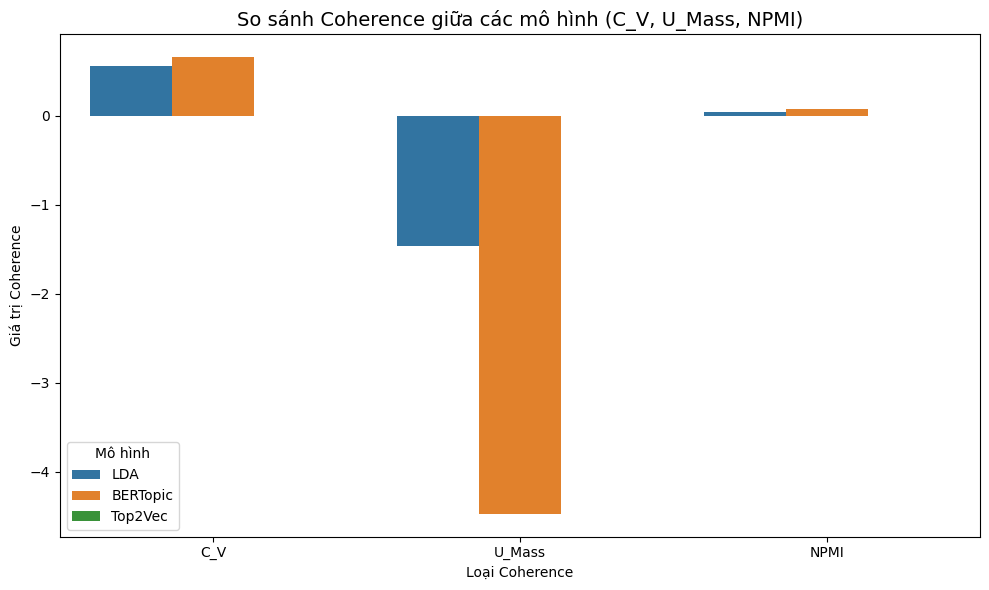

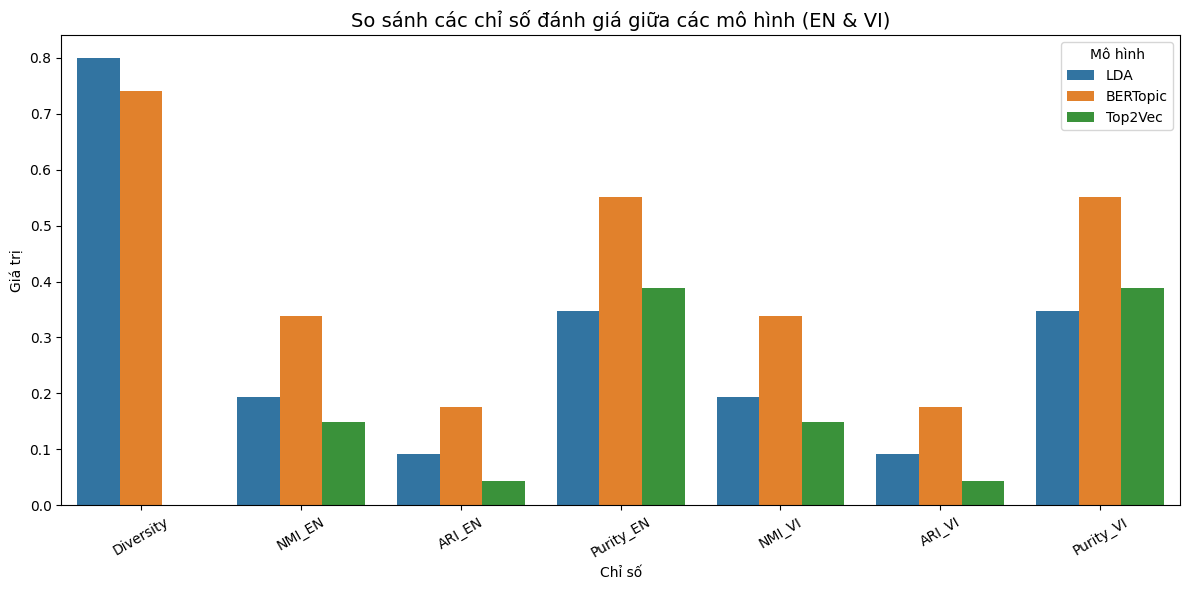

In [10]:
# --- Đảm bảo đúng kiểu dữ liệu ---
eval_df = eval_df.fillna(0)

# --- Biểu đồ Coherence ---
coherence_metrics = ["C_V", "U_Mass", "NPMI"]
plt.figure(figsize=(10, 6))
sns.barplot(data=eval_df.melt(id_vars="Model", value_vars=coherence_metrics,
                              var_name="Metric", value_name="Score"),
            x="Metric", y="Score", hue="Model")
plt.title("So sánh Coherence giữa các mô hình (C_V, U_Mass, NPMI)", fontsize=14)
plt.ylabel("Giá trị Coherence")
plt.xlabel("Loại Coherence")
plt.legend(title="Mô hình")
plt.tight_layout()
plt.show()

# --- Biểu đồ các chỉ số khác (gồm cả EN & VI) ---
other_metrics = [
    "Diversity", 
    "NMI_EN", "ARI_EN", "Purity_EN",
    "NMI_VI", "ARI_VI", "Purity_VI"
]

# Chuyển đổi dạng dữ liệu để vẽ
plot_df = eval_df.melt(id_vars="Model", value_vars=other_metrics,
                       var_name="Metric", value_name="Score")

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="Metric", y="Score", hue="Model")

# Tuỳ chỉnh giao diện
plt.title("So sánh các chỉ số đánh giá giữa các mô hình (EN & VI)", fontsize=14)
plt.ylabel("Giá trị")
plt.xlabel("Chỉ số")
plt.xticks(rotation=30)
plt.legend(title="Mô hình")
plt.tight_layout()
plt.show()

1. Coherence của mô hình LDA

C_V = 0.564 → mức độ nhất quán giữa các từ khóa trong chủ đề khá tốt, cho thấy LDA đã trích xuất được các cụm từ có liên hệ ngữ nghĩa.

U_Mass = -1.46 → giá trị âm nhưng không quá lớn, phản ánh chủ đề đã tách biệt tương đối rõ, ít nhiễu hơn so với mô hình có U_Mass quá âm.

NPMI = 0.0398 → ở mức thấp, nghĩa là mức đồng xuất hiện giữa các từ khóa trong cùng một chủ đề vẫn chưa cao.

Nhìn chung, LDA tạo ra các chủ đề có ý nghĩa nhất định và độ nhất quán khá tốt, nhưng vẫn có thể cải thiện thêm về mức gắn kết giữa các từ khóa trong cùng chủ đề.

2. So sánh hiệu suất giữa các mô hình chủ đề

BERTopic đạt điểm Coherence cao nhất (C_V = 0.66) cùng với các chỉ số phân cụm NMI = 0.34, ARI = 0.18, Purity = 0.55, thể hiện khả năng phân nhóm tài liệu chính xác, ổn định và tạo chủ đề mạch lạc hơn hẳn so với hai mô hình còn lại.

LDA có Diversity cao nhất (0.80), chứng tỏ các chủ đề sinh ra ít trùng lặp, đa dạng và bao quát nhiều khía cạnh của dữ liệu — phù hợp khi muốn tìm phổ rộng các chủ đề tiềm ẩn.

Top2Vec có các chỉ số coherence bằng 0 và NMI/ARI thấp nhất (NMI = 0.15, ARI = 0.04), cho thấy mô hình chưa tách biệt rõ ràng giữa các nhóm tài liệu, có thể do dữ liệu không đủ lớn hoặc embedding chưa được huấn luyện phù hợp.

3. Kết luận tổng quan

BERTopic là mô hình thể hiện hiệu suất tổng thể tốt nhất, vượt trội về độ mạch lạc (Coherence) và khả năng phân cụm.

LDA tuy kém hơn về độ chính xác cụm nhưng có độ đa dạng chủ đề cao, thích hợp để khám phá nội dung phong phú.

Top2Vec chưa đạt hiệu quả trên tập dữ liệu này và có thể cần tinh chỉnh embedding hoặc dữ liệu huấn luyện nhiều hơn.

In [10]:
def plot_topics_wordcloud(model, model_type="LDA", top_n=20, ncols=3, max_topics=5):
    """
    Vẽ WordCloud cho tối đa 'max_topics' topic đầu của mô hình (LDA, BERTopic, Top2Vec v<=1.0.36).
    - model_type in {"LDA", "BERTopic", "Top2Vec"}
    - top_n: số từ lấy cho mỗi topic
    - max_topics: số topic tối đa muốn hiển thị (mặc định = 5)
    """
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    # === Xác định danh sách topic ===
    if model_type == "LDA":
        topic_ids = list(range(model.num_topics))[:max_topics]

    elif model_type == "BERTopic":
        topic_info = model.get_topic_info()
        topic_ids = [int(t) for t in topic_info.Topic.tolist() if int(t) != -1][:max_topics]

    elif model_type == "Top2Vec":
        try:
            t_words_list, t_scores_list, t_nums = model.get_topics()
            topic_ids = list(range(len(t_nums)))[:max_topics]
        except Exception as e:
            raise RuntimeError("Top2Vec: không lấy được topics via get_topics(): %s" % e)
    else:
        raise ValueError("model_type must be 'LDA', 'BERTopic', or 'Top2Vec'")

    n_topics = len(topic_ids)
    if n_topics == 0:
        print("Không có topic nào để vẽ.")
        return

    # === Tạo layout ===
    nrows = math.ceil(n_topics / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = axes.flatten()

    for idx, tpos in enumerate(topic_ids):
        freqs = {}

        if model_type == "LDA":
            words_probs = model.show_topic(tpos, topn=top_n)
            freqs = {w: float(p) for w, p in words_probs}

        elif model_type == "BERTopic":
            topic_words = model.get_topic(int(tpos))
            if not topic_words:
                axes[idx].axis("off")
                continue
            freqs = {w: float(p) for w, p in topic_words[:top_n]}

        elif model_type == "Top2Vec":
            words_list = t_words_list
            scores_list = t_scores_list
            if tpos >= len(words_list) or tpos >= len(scores_list):
                axes[idx].axis("off")
                continue
            words = words_list[tpos][:top_n]
            scores = scores_list[tpos][:top_n]
            if len(words) == 0:
                axes[idx].axis("off")
                continue

            scores = np.array(scores, dtype=float)
            if scores.max() - scores.min() < 1e-9:
                norm = np.linspace(1.0, 0.2, num=len(scores))
            else:
                norm = (scores - scores.min()) / (scores.max() - scores.min()) + 0.001
            freqs = dict(zip(words, norm))

        # === Vẽ WordCloud ===
        if len(freqs) > 0:
            wc = WordCloud(width=400, height=200, background_color="white")
            wc.generate_from_frequencies(freqs)
            axes[idx].imshow(wc, interpolation="bilinear")
            axes[idx].axis("off")
            axes[idx].set_title(f"Topic {tpos}", fontsize=12)
        else:
            axes[idx].axis("off")

    # Ẩn subplot thừa
    for i in range(n_topics, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

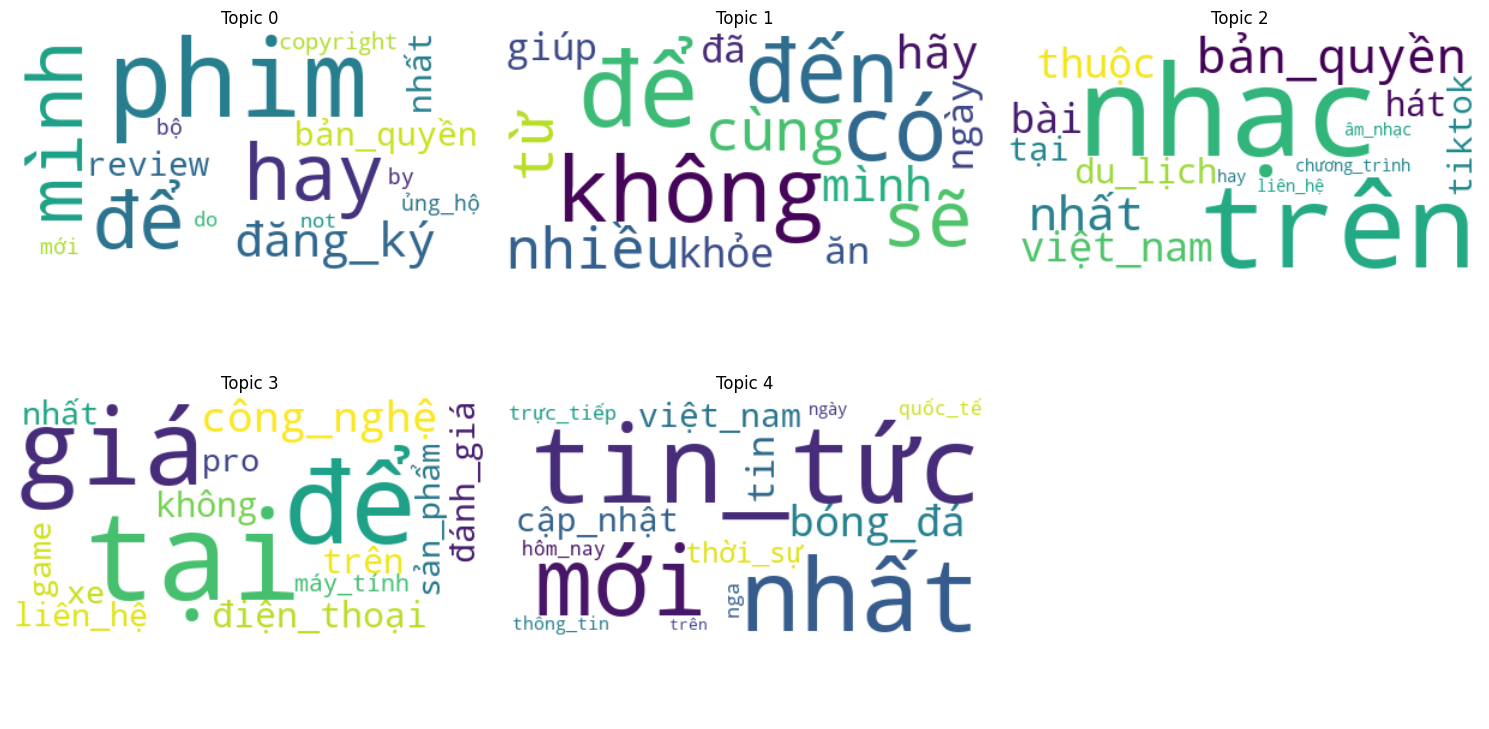

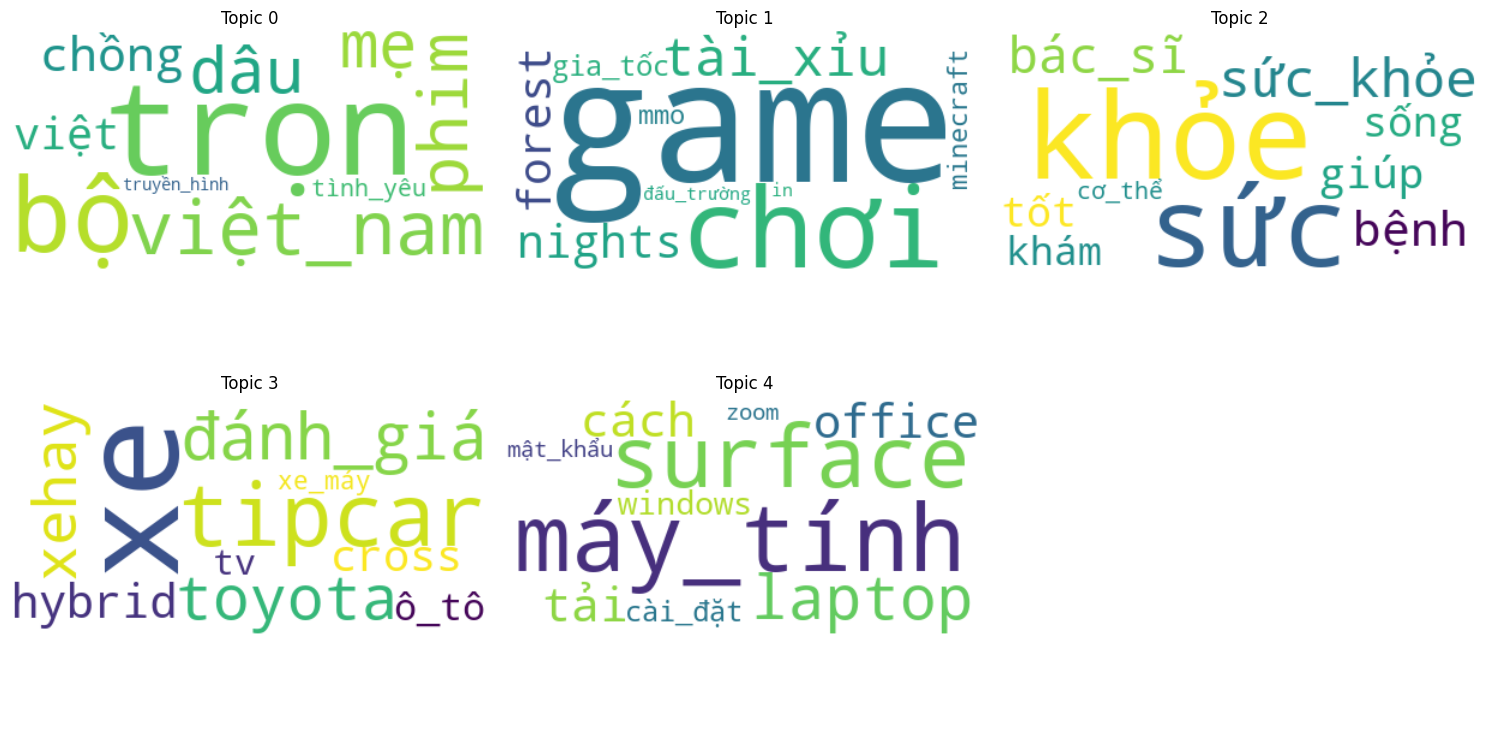

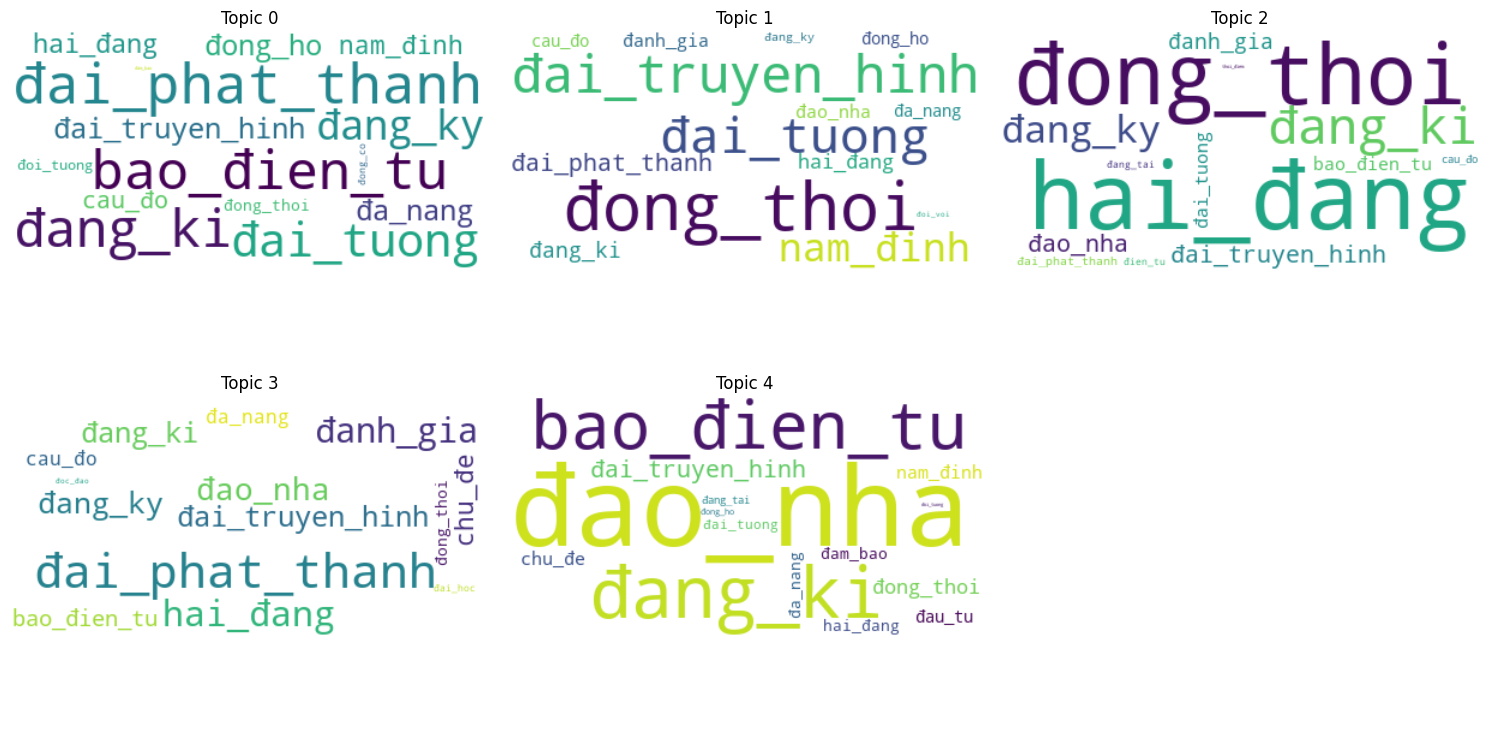

In [12]:
# LDA
plot_topics_wordcloud(lda_model, model_type="LDA", top_n=15)

# BERTopic
plot_topics_wordcloud(bertopic_model, model_type="BERTopic", top_n=15)

# Top2Vec
plot_topics_wordcloud(top2vec_model, model_type="Top2Vec", top_n=15)

**Phân tích trực quan wordcloud**:

- LDA

Các chủ đề khá phân tán, nhiều từ khóa phổ biến như “game”, “review”, “youtube”, “bóng đá”, “du lịch”,...

Một số chủ đề bị trộn lẫn giữa các lĩnh vực khác nhau → cho thấy mô hình chủ yếu dựa vào tần suất từ, chưa hiểu ngữ cảnh sâu.

- BERTopic

Các chủ đề rõ nghĩa và mang tính ngữ cảnh tốt hơn:

Chủ đề về thể thao (“bóng đá”, “hcm”, “highlight”),

giải trí / nhạc (“remix”, “bolero”, “ca khúc”),

công nghệ / sản phẩm (“iphone”, “review”, “phần mềm”),

sức khỏe / tin tức / học tập.

Các từ khóa đồng xuất hiện logic hơn, giúp mô hình dễ diễn giải và ứng dụng thực tế.

- Top2Vec

Các từ khóa tập trung mạnh vào một số cụm lặp lại (“đăng_ký”, “đài_truyền_hình”, “đồng_hành”), thể hiện xu hướng gộp nhiều văn bản có từ đồng dạng thay vì ngữ nghĩa tương đồng.

Chủ đề ít đa dạng, nhiều cụm gần như trùng nhau → mô hình chưa phân biệt tốt ý nghĩa nội dung.

In [13]:
def visualize_topics_bubble(model, model_type="LDA", pred_topics=None):
    """
    Vẽ Bubble Chart biểu diễn độ quan trọng hoặc kích thước của các chủ đề
    cho các mô hình LDA / BERTopic / Top2Vec.
    """
    print(f"=== Bubble Chart: {model_type} ===")
    try:
        if model_type == "BERTopic":
            topic_info = model.get_topic_info()
            topic_sizes = topic_info["Count"].values
            topics = np.arange(len(topic_sizes))

        elif model_type == "Top2Vec":
            # Hàm get_topics() trả về (topic_words, word_scores, topic_nums)
            topic_words, word_scores, topic_nums = model.get_topics()
            topic_sizes = np.array([len(words) for words in topic_words])
            topics = np.arange(len(topic_sizes))

        elif model_type == "LDA":
            if pred_topics is not None:
                df = pd.DataFrame({"topic": pred_topics})
                topic_sizes = df["topic"].value_counts().sort_index().values
                topics = np.arange(len(topic_sizes))
            else:
                topic_sizes = np.arange(model.num_topics)
                topics = np.arange(model.num_topics)
        else:
            raise ValueError("model_type phải là 'LDA', 'BERTopic' hoặc 'Top2Vec'")

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            topics, topic_sizes,
            s=topic_sizes * 10, alpha=0.6, c=topics, cmap="viridis"
        )
        plt.title(f"Topic Importance Bubble Chart - {model_type}",
                  fontsize=14, fontweight='bold')
        plt.xlabel("Chủ đề")
        plt.ylabel("Kích thước hoặc độ quan trọng")
        plt.colorbar(scatter, label="Chủ đề")
        plt.grid(alpha=0.3)
        plt.show()
    except Exception as e:
        print(f"Không thể vẽ bubble chart: {e}")


=== Bubble Chart: LDA ===


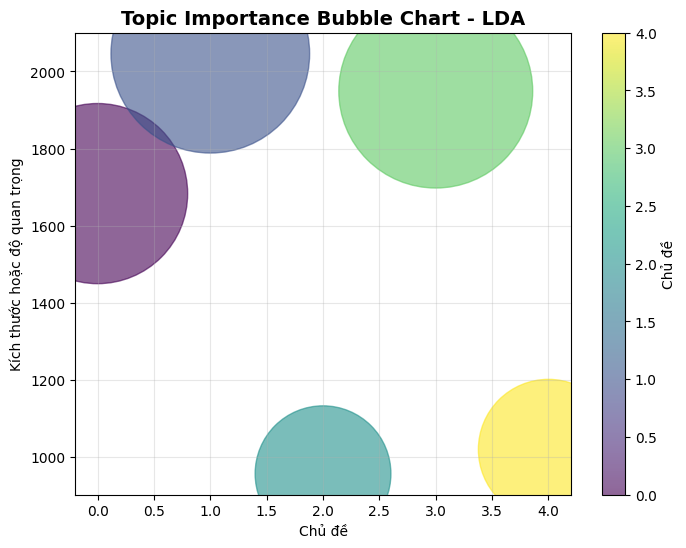

=== Bubble Chart: BERTopic ===


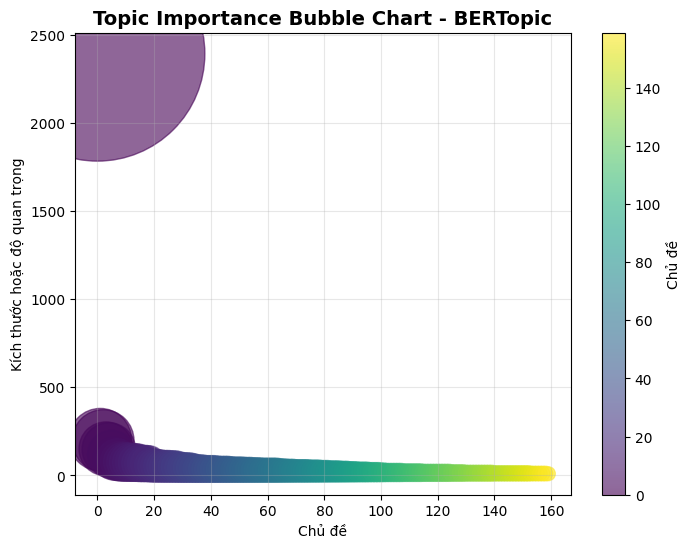

=== Bubble Chart: Top2Vec ===


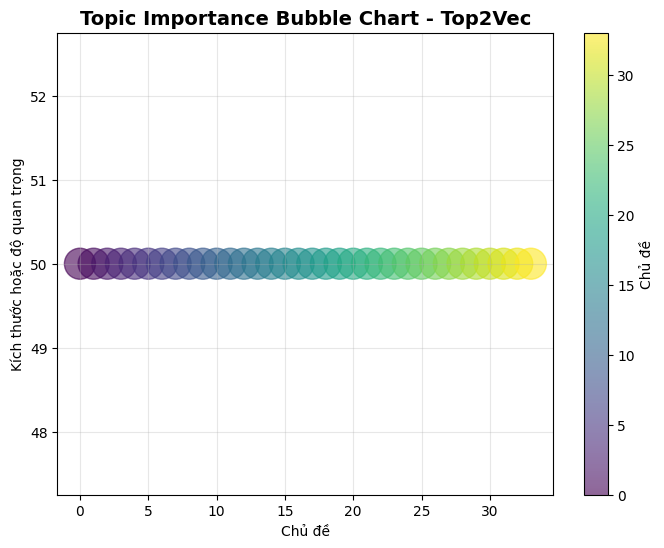

In [14]:
# LDA
visualize_topics_bubble(lda_model, model_type="LDA", pred_topics=lda_pred_topics)

# BERTopic
visualize_topics_bubble(bertopic_model, model_type="BERTopic", pred_topics=bertopic_pred_topics)

# Top2Vec
visualize_topics_bubble(top2vec_model, model_type="Top2Vec", pred_topics=top2vec_pred_topics)

**Kết luận tổng quan**

LDA: Chủ đề phân bố đa dạng, một số chủ đề chiếm ưu thế. Tốt để nhận diện các chủ đề phổ biến nhất

BERTopic: Dữ liệu tập trung vào ít chủ đề chính, thích hợp để phân tách chi tiết chủ đề ít phổ biến

Top2Vec: Phân bố chủ đề đồng đều, không có chủ đề nào áp đảo. Tốt cho việc phân tích tổng quan cân bằng

# CombinedTM

In [7]:
docs = texts
if isinstance(docs[0], list):
    docs = [" ".join(doc) for doc in docs]

# --- LDA ---
num_topics = lda_model.num_topics
lda_doc_emb = np.zeros((len(corpus), num_topics))
for i, doc in enumerate(lda_model[corpus]):
    for topic_id, prob in doc:
        lda_doc_emb[i, topic_id] = prob

# --- BERTopic ---
bertopic_topics, _ = bertopic_model.fit_transform(docs)
bertopic_doc_emb = bertopic_model._extract_embeddings(docs)

# --- Chuẩn hóa trước khi PCA ---
scaler = StandardScaler()
bertopic_doc_emb_scaled = scaler.fit_transform(bertopic_doc_emb)

# --- PCA cho BERTopic ---
pca_bert = PCA(n_components=50, random_state=42)
bertopic_doc_emb_pca = pca_bert.fit_transform(bertopic_doc_emb_scaled)

# --- GHÉP EMBEDDING CỦA LDA VÀ BERTopic ---
combined_emb = np.concatenate(
    [lda_doc_emb, bertopic_doc_emb_pca],
    axis=1
)

# --- Chuẩn hóa cuối cùng ---
combined_emb = StandardScaler().fit_transform(combined_emb)

print("Combined embedding shape:", combined_emb.shape)


Batches: 100%|██████████| 240/240 [02:28<00:00,  1.61it/s]
2025-10-25 17:51:54,702 - BERTopic - Embedding - Completed ✓
2025-10-25 17:51:54,703 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-25 17:52:16,504 - BERTopic - Dimensionality - Completed ✓
2025-10-25 17:52:16,506 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-25 17:52:26,270 - BERTopic - Cluster - Completed ✓
2025-10-25 17:52:26,289 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-25 17:52:26,925 - BERTopic - Representation - Completed ✓


Combined embedding shape: (7653, 55)


In [8]:
# Giảm chiều bằng UMAP + gom cụm HDBSCAN
# Giảm chiều bằng UMAP
reducer = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
umap_embeddings = reducer.fit_transform(combined_emb)

# Gom cụm bằng HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=5,
    metric='euclidean',
    cluster_selection_method='eom'
)
combined_topics = clusterer.fit_predict(umap_embeddings)

# Lưu kết quả
df_combined = pd.DataFrame({
    "document": docs,
    "combined_topic": combined_topics,
    "stability": clusterer.probabilities_
})

print(df_combined.head())
print("Độ ổn định trung bình:", np.mean(clusterer.probabilities_))

                                            document  combined_topic  \
0  đây link ráp_động_tác nhạc lại hiện lên tuyển_...              25   
1  khiêu vũ_bachata hướng_dẫn khiêu_vũ dân_vũ mới...              -1   
2  hướng_dẫn ăn chân gà chanh sao đúng cách tuyển...              -1   
3        đăng_kí để ủng_hộ mình chúc vui_vẻ nhảy_mẫu              32   
4  nhảy dân_vũ_bài tái_sinh hướng_dẫn khiêu_vũ dâ...              -1   

   stability  
0        1.0  
1        0.0  
2        0.0  
3        1.0  
4        0.0  
Độ ổn định trung bình: 0.5481113073461104


In [14]:
# =====================================
# CHUẨN HÓA DỮ LIỆU ĐẦU VÀO
# =====================================
if isinstance(docs[0], list):
    docs = [" ".join(doc) for doc in docs]

texts = [d.split() for d in docs]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(t) for t in texts]

# =====================================
# KIỂM TRA & LẤY NHÃN TỪ BERTopic + COMBINEDTM
# =====================================
if "bertopic_topic" not in df_combined.columns:
    bertopic_topics, _ = bertopic_model.fit_transform(docs)
    df_combined["bertopic_topic"] = bertopic_topics

if "combined_topic" not in df_combined.columns:
    raise ValueError("Thiếu cột 'combined_topic' trong df_combined!")

# =====================================
# GHÉP CATEGORY TỪ DF GỐC NẾU CHƯA CÓ
# =====================================
if "category_name" not in df_combined.columns:
    # Ưu tiên merge theo category_id nếu có
    if "category_id" in df_combined.columns and "category_id" in df.columns:
        df_combined = df_combined.merge(
            df[["category_id", "category_name"]],
            on="category_id", how="left"
        )
    # Nếu không có category_id, thử merge theo index (dòng tương ứng)
    elif "category_name" in df.columns:
        df_combined["category_name"] = df["category_name"]
    else:
        raise KeyError("Không tìm thấy 'category_name' hoặc 'category_id' trong df gốc để ghép vào df_combined.")

# Thêm cột tiếng Việt
df_combined["category_name_vi"] = df_combined["category_name"].map(category_vi).fillna("Khác")

true_labels = df_combined["category_name_vi"].astype(str).values
pred_labels = df_combined["combined_topic"].values

# =====================================
# LẤY TỪ KHÓA CHỦ ĐỀ TỪ BERTopic
# =====================================
def get_topic_words(model, top_n=10):
    """Lấy danh sách các topic [[word1, word2, ...], ...]"""
    if hasattr(model, "show_topics"):  
        # LDA (gensim)
        topics = model.show_topics(num_topics=-1, num_words=top_n, formatted=False)
        topic_words = [[word for word, _ in words] for _, words in topics]
    elif hasattr(model, "get_topic"):
        # BERTopic
        topics = [model.get_topic(i) for i in model.get_topics().keys() if i != -1]
        topic_words = [[w for w, _ in ws[:top_n]] for ws in topics if ws]
    else:
        raise ValueError("Không nhận dạng được loại mô hình chủ đề (chỉ hỗ trợ LDA & BERTopic).")
    return topic_words

topic_words = get_topic_words(bertopic_model, top_n=10)

# =====================================
# TÍNH COHERENCE VÀ DIVERSITY
# =====================================
cm_cv = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='c_v')
cm_umass = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='u_mass')
cm_npmi = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='c_npmi')

cv = cm_cv.get_coherence()
umass = cm_umass.get_coherence()
npmi = cm_npmi.get_coherence()

unique_words = set()
total_words = 0
for words in topic_words:
    for word in words[:10]:
        unique_words.add(word)
        total_words += 1
diversity = len(unique_words) / total_words if total_words > 0 else 0

# =====================================
# TÍNH NMI, ARI, PURITY SO VỚI NHÃN THẬT
# =====================================
def purity_score(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(np.max(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

# Loại bỏ outlier nếu có
mask = pred_labels != -1
true_labels = true_labels[mask]
pred_labels = pred_labels[mask]

nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)
purity = purity_score(true_labels, pred_labels)

# =====================================
# TÍNH STABILITY (nếu có)
# =====================================
mean_stability = np.mean(df_combined["stability"]) if "stability" in df_combined.columns else np.nan

# =====================================
# TỔNG HỢP KẾT QUẢ
# =====================================
results = pd.DataFrame([{
    "Model": "CombinedTM (LDA + BERTopic)",
    "C_V": cv,
    "U_Mass": umass,
    "NPMI": npmi,
    "Diversity": diversity,
    "NMI (vs True Category)": nmi,
    "ARI (vs True Category)": ari,
    "Purity (vs True Category)": purity,
    "Mean_Stability": mean_stability
}])

print("\n=== KẾT QUẢ ĐÁNH GIÁ COMBINEDTM SO VỚI CATEGORY THẬT ===")
print(results.round(4))



=== KẾT QUẢ ĐÁNH GIÁ COMBINEDTM SO VỚI CATEGORY THẬT ===
                         Model     C_V  U_Mass    NPMI  Diversity  \
0  CombinedTM (LDA + BERTopic)  0.6628 -4.5257  0.0757     0.7481   

   NMI (vs True Category)  ARI (vs True Category)  Purity (vs True Category)  \
0                  0.3385                  0.0679                     0.5626   

   Mean_Stability  
0          0.5481  


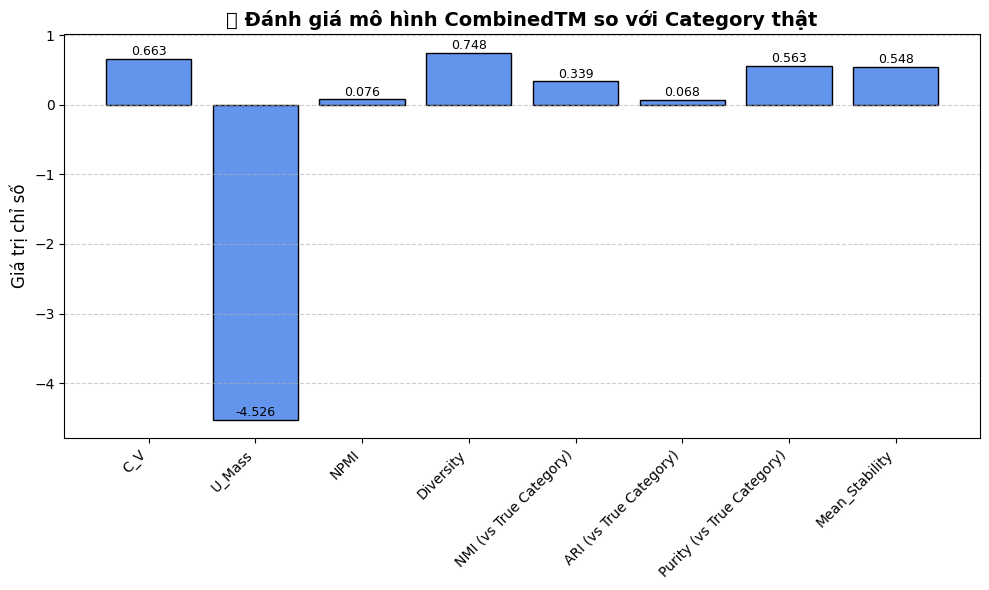

In [15]:
# Lấy các cột chỉ số (bỏ cột "Model")
metrics = results.drop(columns=["Model"]).T
metrics.columns = ["CombinedTM"]
metrics.reset_index(inplace=True)
metrics.columns = ["Metric", "Score"]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics["Metric"], metrics["Score"], color="cornflowerblue", edgecolor="black")

# Thêm tiêu đề và trục
plt.title("📊 Đánh giá mô hình CombinedTM so với Category thật", fontsize=14, fontweight="bold")
plt.ylabel("Giá trị chỉ số", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Ghi giá trị trên cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha="center", va="bottom", fontsize=9)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


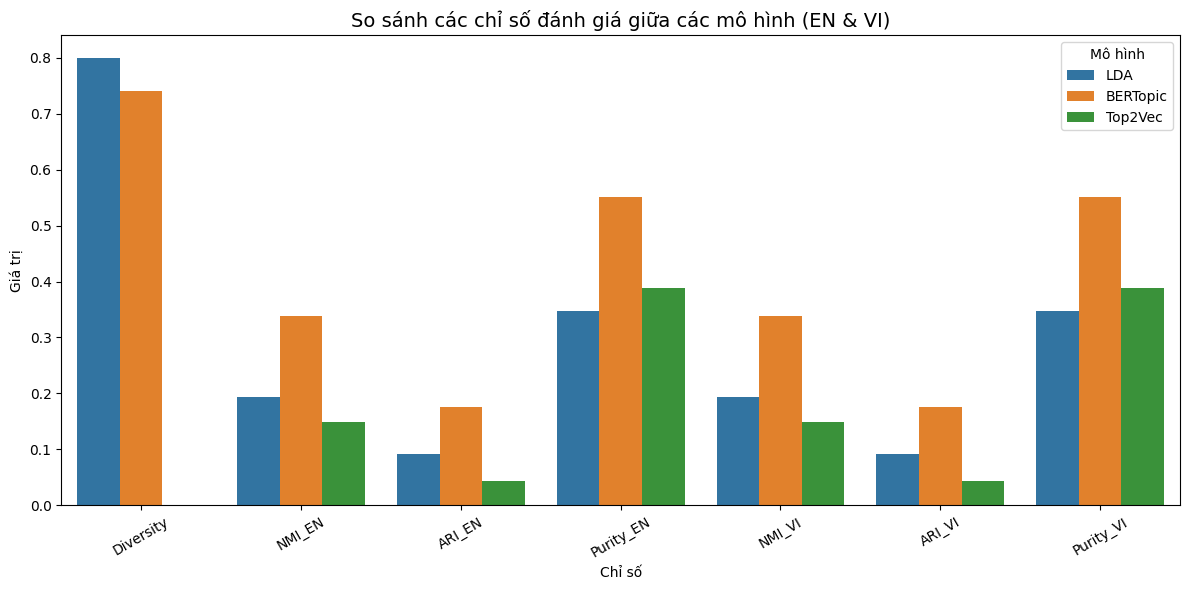

In [20]:
# =====================================
# 1. GAN CAC COT TOPIC ID VAO DF
# =====================================
df["lda_topic"] = lda_pred_topics
df["bertopic_topic"] = bertopic_pred_topics
df["top2vec_topic"] = top2vec_pred_topics

# Neu df_combined co cot combined_topic thi lay, neu khong thi tao mac dinh
if "combined_topic" in df_combined.columns:
    df["combined_topic"] = df_combined["combined_topic"].values
else:
    df["combined_topic"] = -1  # fallback

print("Da them cot topic ID cho LDA, BERTopic, Top2Vec, CombinedTM.")


# =====================================
# 2. TRICH XUAT TEN CHU DE TU 3 MO HINH
# =====================================
def extract_topic_labels(model, model_name, top_n=5):
    """Trich xuat danh sach cac tu khoa dai dien cho tung topic."""
    topics_dict = {}

    if model_name.lower() == "lda":
        topics = model.show_topics(num_topics=-1, num_words=top_n, formatted=False)
        for topic_id, words in topics:
            topics_dict[topic_id] = ", ".join([w for w, _ in words])

    elif model_name.lower() == "bertopic":
        for topic_id in model.get_topics().keys():
            if topic_id != -1:
                topics_dict[topic_id] = ", ".join(
                    [w for w, _ in model.get_topic(topic_id)[:top_n]]
                )

    elif model_name.lower() == "top2vec":
        topic_words, _, _ = model.get_topics()
        for i, words in enumerate(topic_words):
            topics_dict[i] = ", ".join(words[:top_n])

    return topics_dict


lda_topics_dict = extract_topic_labels(lda_model, "lda")
bertopic_topics_dict = extract_topic_labels(bertopic_model, "bertopic")
top2vec_topics_dict = extract_topic_labels(top2vec_model, "top2vec")

print("Da trich xuat ten chu de cho LDA, BERTopic, Top2Vec.")


# =====================================
# 3. GAN TEN CHU DE VA TAO COMBINEDTM DUOC DIEN GIAI
# =====================================
df["lda_topic_name"] = df["lda_topic"].map(lda_topics_dict).fillna("Unknown")
df["bertopic_topic_name"] = df["bertopic_topic"].map(bertopic_topics_dict).fillna("Unknown")
df["top2vec_topic_name"] = df["top2vec_topic"].map(top2vec_topics_dict).fillna("Unknown")

# --- Tao ten cho CombinedTM ---
from collections import Counter
import re

def top_keywords_in_topic(df, topic_col, text_col, top_n=5):
    topic_keywords = {}
    for topic_id, group in df.groupby(topic_col):
        if topic_id == -1 or group.empty:
            continue
        all_words = " ".join(group[text_col]).lower()
        tokens = re.findall(r"\b\w+\b", all_words)
        common = [w for w, _ in Counter(tokens).most_common(top_n)]
        topic_keywords[topic_id] = ", ".join(common)
    return topic_keywords

# Sinh tu khoa dai dien cho CombinedTM neu co
combined_keywords = top_keywords_in_topic(df, "combined_topic", "clean_description", top_n=5)

# Gan ten CombinedTM ket hop giua LDA + BERTopic neu co ca hai
def make_combined_name(row):
    if row["lda_topic_name"] != "Unknown" and row["bertopic_topic_name"] != "Unknown":
        return f"{row['lda_topic_name']} | {row['bertopic_topic_name']}"
    elif row["combined_topic"] in combined_keywords:
        return combined_keywords[row["combined_topic"]]
    else:
        return f"Topic {row['combined_topic']}"

df["combined_topic_name"] = df.apply(make_combined_name, axis=1)

print("Da gan ten chu de (string) cho tat ca mo hinh, bao gom CombinedTM.")


# =====================================
# 4. LUU KET QUA RA FILE
# =====================================
output_path = "C:/Users/thean/Documents/Social_Network/Social_Network_Projects/Dataset/df_with_all_topics.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"Da luu ket qua gan topic vao file: {output_path}")


Da them cot topic ID cho LDA, BERTopic, Top2Vec, CombinedTM.
Da trich xuat ten chu de cho LDA, BERTopic, Top2Vec.
Da gan ten chu de (string) cho tat ca mo hinh, bao gom CombinedTM.
Da luu ket qua gan topic vao file: C:/Users/thean/Documents/Social_Network/Social_Network_Projects/Dataset/df_with_all_topics.csv


In [21]:
df_result = pd.read_csv(output_path, encoding="utf-8-sig")
df_result.head(10)

,description,category_id,clean_description,token_count,category_name,category_name_vi,lda_topic,bertopic_topic,top2vec_topic,combined_topic,lda_topic_name,bertopic_topic_name,top2vec_topic_name,combined_topic_name
0,💥💥💥ĐÂY LÀ LINK VIDEO RÁP ĐỘNG TÁC VỚI NHẠC: 💥 ...,26,đây link ráp_động_tác nhạc lại hiện lên tuyển_...,104,Howto & Style,Cách làm & Phong cách,2,51,0,25,"nhạc, trên, bản_quyền, nhất, việt_nam","dance, lớp, nhảy, inbox, tập_luyện","đai_phat_thanh, bao_đien_tu, đang_ki, đai_tuon...","nhạc, trên, bản_quyền, nhất, việt_nam | dance,..."
1,Khiêu vũ bachata [ Hướng Dẫn Khiêu Vũ - Dân Vũ...,22,khiêu vũ_bachata hướng_dẫn khiêu_vũ dân_vũ mới...,9,People & Blogs,Con người & Blog,1,144,1,-1,"để, không, có, đến, sẽ","mơ, nhớ_đời, bóng_đá, cổ_vũ, amorim","đong_thoi, đai_truyen_hinh, đai_tuong, nam_đin...","để, không, có, đến, sẽ | mơ, nhớ_đời, bóng_đá,..."
2,Hướng Dẫn Ăn Chân Gà Chanh Sao Cho Đúng Cách! ...,22,hướng_dẫn ăn chân gà chanh sao đúng cách tuyển...,62,People & Blogs,Con người & Blog,0,6,0,-1,"phim, hay, để, mình, đăng_ký","youtube, tloo, hcm, thủy_sinh, thời_sự","đai_phat_thanh, bao_đien_tu, đang_ki, đai_tuon...","phim, hay, để, mình, đăng_ký | youtube, tloo, ..."
3,Đăng kí kênh để ủng hộ mình nhé! Chúc bạn xem ...,22,đăng_kí để ủng_hộ mình chúc vui_vẻ nhảy_mẫu,7,People & Blogs,Con người & Blog,0,62,4,32,"phim, hay, để, mình, đăng_ký","reno, idea, vt_media, lenovo, tab","đao_nha, đang_ki, bao_đien_tu, đai_truyen_hinh...","phim, hay, để, mình, đăng_ký | reno, idea, vt_..."
4,NHẢY DÂN VŨ bài TÁI SINH [ Hướng Dẫn Khiêu Vũ ...,22,nhảy dân_vũ_bài tái_sinh hướng_dẫn khiêu_vũ dâ...,10,People & Blogs,Con người & Blog,1,144,1,-1,"để, không, có, đến, sẽ","mơ, nhớ_đời, bóng_đá, cổ_vũ, amorim","đong_thoi, đai_truyen_hinh, đai_tuong, nam_đin...","để, không, có, đến, sẽ | mơ, nhớ_đời, bóng_đá,..."
5,Đăng kí kênh để ủng hộ mình nhé! Chúc bạn xem ...,22,đăng_kí để ủng_hộ mình chúc vui_vẻ nhảy_mẫu hư...,8,People & Blogs,Con người & Blog,0,62,4,32,"phim, hay, để, mình, đăng_ký","reno, idea, vt_media, lenovo, tab","đao_nha, đang_ki, bao_đien_tu, đai_truyen_hinh...","phim, hay, để, mình, đăng_ký | reno, idea, vt_..."
6,👉Bài mẫu: https://youtu.be/K-lrkNGZMB8 👉Hai hư...,22,bài mẫu hai hướng nhạc chậm cùng chiều link mì...,12,People & Blogs,Con người & Blog,2,32,14,25,"nhạc, trên, bản_quyền, nhất, việt_nam","tr, iphone, giá, pro, max","đanh_gia, đia_chi_so, đang_ki, hai_đang, đai_p...","nhạc, trên, bản_quyền, nhất, việt_nam | tr, ip..."
7,#guitar đệm hát #introguitar Chào mừng các bạn...,22,đệm hát chào_mừng yêu âm_nhạc đã đến trần_tùng...,124,People & Blogs,Con người & Blog,1,95,0,28,"để, không, có, đến, sẽ","đồng_tháp, showroom, website_facebook, thdt, f...","đai_phat_thanh, bao_đien_tu, đang_ki, đai_tuon...","để, không, có, đến, sẽ | đồng_tháp, showroom, ..."
8,"Động tác đơn giản hỗ trợ giảm đau lưng dưới, a...",17,động_tác đơn_giản hỗ_trợ giảm đau lưng dưới ai...,109,Sports,Thể thao,1,-1,0,-1,"để, không, có, đến, sẽ",Unknown,"đai_phat_thanh, bao_đien_tu, đang_ki, đai_tuon...",Topic -1
9,[SPRUNKI] Cappuccina hướng dẫn Tung Tung Sahur...,22,sprunki cappuccina hướng_dẫn tung sahur ăn_mì ...,9,People & Blogs,Con người & Blog,1,-1,5,68,"để, không, có, đến, sẽ",Unknown,"đoi_song, đong_ho, đong_co, đong_thoi, tac_đong","ăn, món, để, không, ngon"
